## Introduction
### Resources used
* For loading dataset in kaggle: https://towardsdatascience.com/setting-up-kaggle-in-google-colab-ebb281b61463
* For exploring data and training the model, the code was adapted from this notebook: https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb

## Loading dataset from kaggle

In [1]:
!pip install kaggle

In [2]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [3]:
import getpass
print("Paste the content from kaggle.json, then press Enter:")
tokenString = getpass.getpass()
with open('/content/.kaggle/kaggle.json', 'w') as file:
  file.write(tokenString)

Paste the content from kaggle.json, then press Enter:
··········


In [4]:
!mkdir /root/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign -p /content/skin-cancer-data

skin-cancer-malignant-vs-benign.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!cd skin-cancer-data; unzip *.zip

Archive:  skin-cancer-malignant-vs-benign.zip
replace data/test/benign/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
  inflating: test/benign/1.jpg       
  inflating: test/benign/10.jpg      
  inflating: test/benign/1003.jpg    
  inflating: test/benign/1006.jpg    
  inflating: test/benign/1013.jpg    
  inflating: test/benign/1018.jpg    
  inflating: test/benign/1019.jpg    
  inflating: test/benign/1023.jpg    
  inflating: test/benign/1025.jpg    
  inflating: test/benign/1029.jpg    
  inflating: test/benign/1033.jpg    
  inflating: test/benign/1034.jpg    
  inflating: test/benign/1042.jpg    
  inflating: test/benign/1044.jpg    
  inflating: test/benign/105.jpg     
  inflating: test/benign/1055.jpg    
  inflating: test/benign/1061.jpg    
  inflating: test/benign/1070.jpg    
  inflating: test/benign/1074.jpg    
  inflating: test/benign/1077.jpg    
  inflating: test/benign/1080.jpg    
  inflating: test/benign/1087.jpg    
  inflating: test/benign/1088.jpg    
  inflat

In [10]:
!ls skin-cancer-data

data  models  skin-cancer-malignant-vs-benign.zip  test  train	valid


## Exploring the data

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [0]:
!mv /content/skin-cancer-data/test /content/skin-cancer-data/valid

In [0]:
data = ImageDataBunch.from_folder("/content/skin-cancer-data")

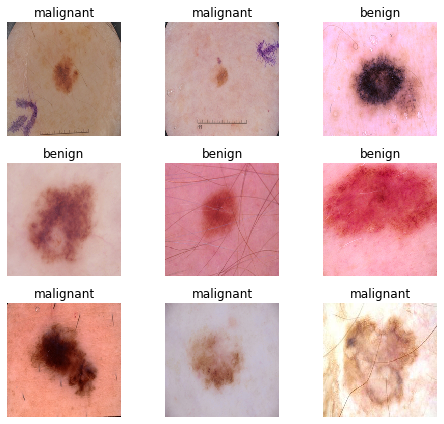

In [16]:
data.show_batch(rows=3, figsize=(7,6))

In [17]:
print(data.classes)

['benign', 'malignant']


## Training: resnet34

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [19]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [20]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [21]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.725312,0.658782,0.196970,00:25
1,0.543555,0.408886,0.162121,00:22
2,0.381132,0.347180,0.154545,00:23
3,0.292243,0.348781,0.154545,00:23


In [0]:
learn.save('stage-1')


## Results

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

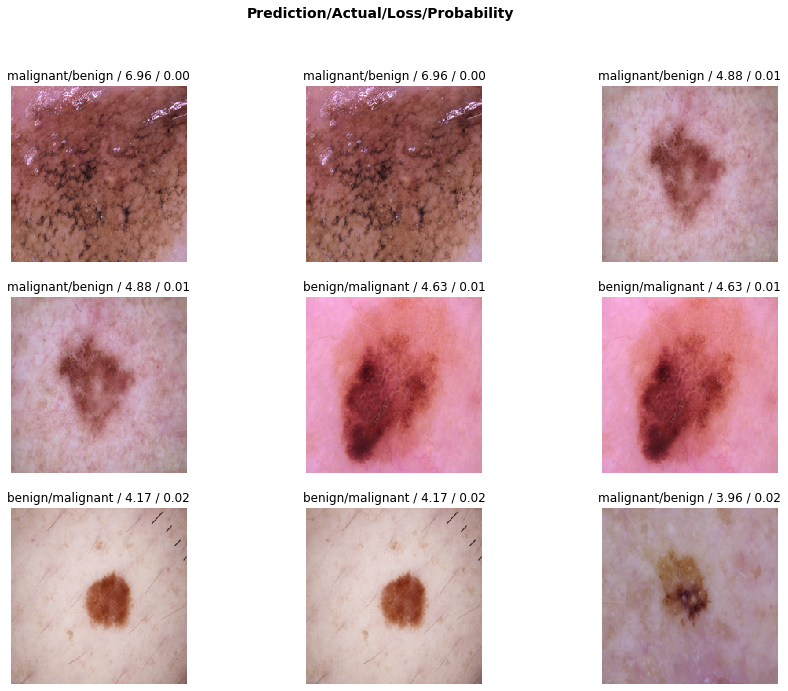

In [24]:
interp.plot_top_losses(9, figsize=(15,11))


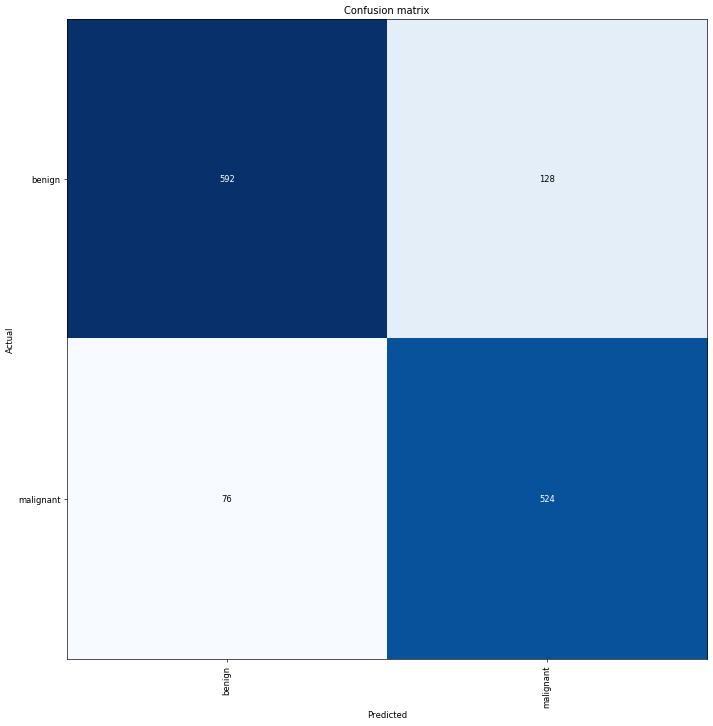

In [25]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


## Unfreezing, fine-tuning, and learning rates

In [26]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [27]:
learn.unfreeze()
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [28]:
learn.unfreeze()
learn.fit_one_cycle(1)


epoch,train_loss,valid_loss,error_rate,time
0,0.384175,0.354822,0.151515,00:31


In [29]:
learn.load('stage-1');
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


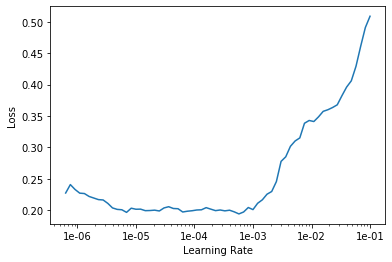

In [30]:
learn.recorder.plot()


In [31]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.214215,0.331963,0.142424,00:30
1,0.177183,0.323322,0.140909,00:30


In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In [0]:
learn.save('stage-2');